# Measuring the spatial frequency dependence of mixture summation
## Thesis chapter 2

Here, we'll organize (better than has been organized in the predecesor notebooks __{analysis_ch2, analysis_ch3}__ the analysis for chapter 1 of my thesis.

Last access (y.m.d): 23.01.24  
Last update (y.m.d): 23.01.24

### Contents
1. Superposition (mixtures)
2. Masks (sfBB)

In [2174]:
oy = hf.np_smart_load('LGN/sach/structures/sachData.npy')

In [225]:
import pandas as pd
pd.set_option('display.float_format', '{:.3f}'.format)

import pdb
import model_responses_pytorch as mrpt
import plot_superposition_func as psf
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

import warnings
warnings.filterwarnings(action='once')

import numpy as np
import os
import helper_fcns as hf
import helper_fcns_sfBB as hf_sfBB
# import model_responses as mr
import scipy.stats as ss
import scipy.odr.odrpack as odrpack
from scipy.stats.mstats import gmean
from scipy.stats import ks_2samp, kstest, linregress
import itertools
import autoreload
from IPython.core.display import display, HTML, Image

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import matplotlib.backends.backend_pdf as pltSave
from matplotlib.ticker import FuncFormatter

from helper_fcns_sfBB import compute_f1f0 as bb_compute_f1f0
from helper_fcns_sfBB import get_resp_str

import plot_sf_figs as psf

# plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');

base_dir = os.getcwd() + '/';

%matplotlib inline

In [1059]:
from matplotlib import rcParams

tex_width = 469; # per \layout in Overleaf on document
sns_offset = 2; 
hist_width = 0.9;
hist_ytitle = 0.94; # moves the overall title a bit further down on histogram plots0

rcParams.update(mpl.rcParamsDefault)

fontsz = 12;
tick_scalar = 1.5;

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

usetex = False

rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
params = {'text.usetex' : usetex,
          'font.size' : fontsz,
          'font.family': 'lmodern',
           'font.style': 'italic'}
plt.rcParams.update(params)

# rcParams['lines.linewidth'] = 2.5;
rcParams['lines.markeredgewidth'] = 0; # no edge, since weird tings happen then
# rcParams['axes.linewidth'] = 2; # was 1.5
# rcParams['lines.markersize'] = 5;

tick_adj = ['xtick.major.size', 'xtick.minor.size', 'ytick.major.size', 'ytick.minor.size']
for adj in tick_adj:
    rcParams[adj] = rcParams[adj] * tick_scalar;
    
%matplotlib inline

date = '_230125'

saveName = 'figures/reports/ch02_SUPERPOS_MASKS%s/' % (date); # for one save name for all figures
save_loc = base_dir + saveName;

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.


# 1. Superposition

In [1986]:
def pearson_r_pandas(to_use, metr_a, metr_b, verbose=False):
    valz = np.transpose(to_use[[metr_a, metr_b]].dropna().values, )
    rv, pv = ss.pearsonr(*valz)
    if verbose:
        print('[n=%d] r2=%.1e, p=%.1e [%s %s]' % (valz.shape[1], rv, pv, metr_a, metr_b))
    return rv, pv, valz.shape[1]

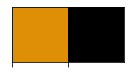

In [1987]:
lgn = hf.np_smart_load('jointList_LGN_230121_vT00_dvT00_jt7.npy')
v1 = hf.np_smart_load('jointList_wMods_V1_230121vE_vT00_dvT00_m3j10.npy')

lgn_full_disps = np.where([len(lgn[x]['metadata']['stimVals'][0])>2 for x in lgn.keys()])[0];
v1_full_disps = np.where([np.logical_and('sfErrsInd_var_prince' in v1[x]['superpos'], len(v1[x]['metadata']['stimVals'][0])>2) for x in v1.keys()])[0];

# set up colors...
colors = sns.color_palette('colorblind', n_colors=2) # lgn color first
colors.append((0,0,0)); # add black!

colors = colors[1:] # ignore the first color
sns.palplot(colors)

In [2123]:
whichExps = ['lgn', 'v1'];

df = None;
area_all = [];
type_all = [];
# vThresh = 10 #-np.Inf
vThresh = 0 #-np.Inf

for which_exp in whichExps:

    which_jl = lgn if which_exp=='lgn' else v1;
    which_nms = lgn_full_disps if  which_exp=='lgn' else v1_full_disps

    if which_jl == lgn:
        full_disps = [len(lgn[x]['metadata']['stimVals'][0])>2 for x in lgn.keys()];
    else:
        full_disps = [np.logical_and('sfErrsInd_var_prince' in v1[x]['superpos'], len(v1[x]['metadata']['stimVals'][0])>2) for x in v1.keys()];

    area = [which_exp] * len(which_jl);
    ####
    # tuning, basic metrics
    # --- note: [0] following jl_get_metric_byCon is to get only the first output (i.e. ignore the con. vals)
    ####
    respMeasure = hf.jl_get_metric_byCon(which_jl, ['respMeasure'], conVal=None, disp=None, fieldOverwrite='metadata')[0]
    if which_exp == 'lgn':
        cellType = np.array([which_jl[x]['metadata']['cellType'] for x in which_jl.keys()])
        non_mp = np.logical_and(~(cellType=='parvo'), ~(cellType=='magno'))
        cellType[non_mp] = 'other'
    elif which_exp == 'v1':
        cellType = respMeasure.astype('bool'); # i.e. cellType becomes 'is it simple?'

    cellNum = hf.jl_get_metric_byCon(which_jl, ['cellNum'], conVal=None, disp=None, fieldOverwrite='metadata')[0].astype('int')
    slps = -hf.jl_get_metric_byCon(which_jl, 'dog_mod_slope', conVal=None, disp=0)[0]
    bw34_split = hf.jl_get_metric_byCon(which_jl, 'dog_bw34_split', conVal=1, disp=0)[0][:, 1]
    bw34 = hf.jl_get_metric_byCon(which_jl, 'dog_bw34', conVal=1, disp=0)[0]
    prefSf = hf.jl_get_metric_byCon(which_jl, 'dog_pSf', conVal=1, disp=0)[0]
    bwHalf_split = hf.jl_get_metric_byCon(which_jl, 'dog_bwHalf_split', conVal=1, disp=0)[0][:, 1]
    bwHalf = hf.jl_get_metric_byCon(which_jl, 'dog_bwHalf', conVal=1, disp=0)[0]
    suprInd_model = hf.jl_get_metric_byCon(which_jl, ['rfsize', 'suprInd_model'], conVal=None, disp=None, fieldOverwrite='basics')[0]
    rfsize = hf.jl_get_metric_byCon(which_jl, ['rfsize', 'gsf_model'], conVal=None, disp=None, fieldOverwrite='basics')[0]
    rfsize_surr = hf.jl_get_metric_byCon(which_jl, ['rfsize', 'surrDiam_model'], conVal=None, disp=None, fieldOverwrite='basics')[0]
    oriBW = hf.jl_get_metric_byCon(which_jl, ['ori', 'bw'], conVal=None, disp=None, fieldOverwrite='basics')[0]
    tfBW = hf.jl_get_metric_byCon(which_jl, ['tf', 'tfBW_oct'], conVal=None, disp=None, fieldOverwrite='basics')[0]
    tfPref = hf.jl_get_metric_byCon(which_jl, ['tf', 'tfPref'], conVal=None, disp=None, fieldOverwrite='basics')[0]
    # other metrics...
    hiCon_varExpl = hf.jl_get_metric_byCon(which_jl, 'dog_varExpl', conVal=1, disp=0)[0] # highest con.
    charFreq = hf.jl_get_metric_byCon(which_jl, 'dog_charFreq', conVal=1, disp=0)[0] # highest con.
    # --- all boot values are NaN for now...would need to re-run
#     charFreq_std = hf.jl_get_metric_byCon(which_jl, 'boot_dog_charFreq_values', conVal=1, disp=0)[0] # highest con.
    f1f0_ratio = hf.jl_get_metric_byCon(which_jl, 'f1f0_ratio', conVal=None, disp=None)[0]
    mn_med_max = hf.jl_get_metric_byCon(which_jl, 'mn_med_max', conVal=None, disp=None)[0]
    mn, md, mx = np.transpose(mn_med_max);
    # c50 stuff (from superposition)
    c50_pref = hf.jl_get_metric_byCon(which_jl, ['disp0_c50'], conVal=None, disp=None, fieldOverwrite='superpos')[0]
    c50_pref_emp = hf.jl_get_metric_byCon(which_jl, ['disp0_c50_emp'], conVal=None, disp=None, fieldOverwrite='superpos')[0]
    ####
    # mixture metrics
    ####
    sfErrs = hf.jl_get_metric_byCon(which_jl, ['sfErrsInd_wtdVar_prince'], conVal=None, disp=None, fieldOverwrite='superpos')[0]
    sfErrs_boot = hf.jl_get_metric_byCon(which_jl, ['sfErrsInd_wtdVar_prince_boot'], conVal=None, disp=None, fieldOverwrite='superpos')[0]
    sfErrs_boot_std = np.nanstd(sfErrs_boot, axis=1)
    sfErrs_boot_mdn = np.nanmedian(sfErrs_boot, axis=1)
    super_varExpl = hf.jl_get_metric_byCon(which_jl, ['var_expl'], conVal=None, disp=None, fieldOverwrite='superpos')[0]
    super_varExpl_boot = hf.jl_get_metric_byCon(which_jl, ['var_expl_boot'], conVal=None, disp=None, fieldOverwrite='superpos')[0]
    super_varExpl_std = np.nanstd(super_varExpl_boot, axis=1)
    super_varExpl_std_clip = np.nanstd(np.clip(super_varExpl_boot, -50, None), axis=1)
    c50_summ = hf.jl_get_metric_byCon(which_jl, ['rel_c50'], conVal=None, disp=None, fieldOverwrite='superpos')[0]
    c50_summ_emp = hf.jl_get_metric_byCon(which_jl, ['rel_c50_emp'], conVal=None, disp=None, fieldOverwrite='superpos')[0]
    c50_summ_emp_boot = hf.jl_get_metric_byCon(which_jl, ['rel_c50_emp_boot'], conVal=None, disp=None, fieldOverwrite='superpos')[0]
    auc = hf.jl_get_metric_byCon(which_jl, ['supr_area'], conVal=None, disp=None, fieldOverwrite='superpos')[0]
    auc_boot_std = np.nanstd(hf.jl_get_metric_byCon(which_jl, ['supr_area_boot'], conVal=None, disp=None, fieldOverwrite='superpos')[0], axis=1)

    # cut out bad cells...
    threshPass = np.logical_and(full_disps, np.sum(super_varExpl_boot>vThresh, axis=1)>(0.95*super_varExpl_boot.shape[1]))
    # --- also make sure that sfErrs_boot_std>0, b/c ==0 only if there are no repeats!
    threshPass = np.logical_and(threshPass, sfErrs_boot_std>0)
    
    curr_df = pd.DataFrame(data=np.transpose([respMeasure, cellNum, f1f0_ratio, hiCon_varExpl, charFreq, prefSf,
                                              slps, bwHalf_split, bwHalf, bw34_split, bw34, rfsize, rfsize_surr, 
                                              suprInd_model, oriBW, tfBW, tfPref, mn, md, mx, c50_pref, c50_pref_emp, 
                                              sfErrs, sfErrs_boot_std, sfErrs_boot_mdn, 
                                              super_varExpl, super_varExpl_std, super_varExpl_std_clip,
                                              auc, auc_boot_std,
                                              c50_summ, c50_summ_emp, full_disps, threshPass]), 
                           columns=['isSimple', 'cellNum', 'f1f0', 'sfVarExpl', 'charFreq',  'prefSf',
                                    'slope', 'bwHalf_split', 'bwHalf', 'bw34_split', 'bw34', 
                                    'rfsize', 'rfsize_surr', 
                                    'suprInd', 'oriBW', 'tfBW', 'tfPref', 'meanResp', 'mdnResp', 'maxResp', 'c50_pref', 'c50_pref_emp', 
                                    'sfErrs', 'sfErrsBootStd', 'sfErrsBootMdn', 
                                    'super_varExpl', 'super_varExpl_std', 'svesc', 
                                    'auc', 'auc_std',
                                    'c50_summ', 'c50_summ_emp', 'isFullDisp', 'threshPass'],)
    area_all.append(area);
    type_all.append(cellType);
    if df is None:
        df = curr_df;
    else:
        df = df.append(curr_df)
    
# adding string fields after to avoid other fields being bad...
df.insert(0, 'area', hf.flatten_list(area_all))
df.insert(1, 'cellType', hf.flatten_list(type_all))
df['threshPass'] = df['threshPass'].astype('bool')
df['cellNum'] = df['cellNum'].astype('int')
df['super_varExpl_clip'] = np.clip(df['super_varExpl'], -10, None);
# why duplicating? to make sns.plots easier (can't handle underscores with latex nonesense)
df['svec'] = df['super_varExpl_clip']
df['c50emp'] = df['c50_pref_emp'];
df['aucStd'] = df['auc_std'];
# df['super_varExpl_clip'] = np.clip(df['super_varExpl'], -10, None);
# now subset to only full!
df_only_full = df[df['isFullDisp'].astype('bool')]
df_only_pass = df_only_full[df_only_full['threshPass']]
df_only_fail = df_only_full[~df_only_full['threshPass']]

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


In [2124]:
# get color scheme
area_colors = [];
toGroups = ['cellType', 'cellType']; # corresponding to LGN, V1

pds_split = [df[df['area']=='lgn'], df[df['area']=='v1']]

for mega, whichArea, toGroup in zip(pds_split, whichExps, toGroups):

    cnt = 0;
    grp_names = [];
    for nm, group in mega.groupby(toGroup, sort=False):
        cnt += 1;
        grp_names.append(nm)

    # colors = cm.viridis(np.linspace(0.15, 0.95, cnt))
    if whichArea=='v1':
#         colors = sns.color_palette('husl', n_colors=cnt-1)
        colors = sns.color_palette('viridis', n_colors=cnt-1)
        colors.append((0,0,0)); # add black!
    else: # lgn...
        # why adding extra colors?
        # well, the 3rd color looks like the first in viridis
        colors = sns.color_palette('colorblind', n_colors=cnt+2)
        # so we'll add extras and swap with the desirable one
        colors[2] = colors[4]
        colors = sns.color_palette(colors[0:3])
        
    area_colors.append(colors)

### 6.0: How much does the Naka-Rushton fit to the data explain mixture summation?

In [2125]:
# NOTE: Rough template for making per-group (i.e. m/p/o, s/c) plots...
# sns.histplot(data=which_data[which_data['area']=='v1'], x='svec', multiple='stack', 
#              hue='cellType', palette=area_colors[1], bins=bins)

<>:47: DeprecationWarning: invalid escape sequence \%


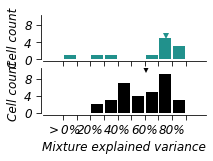

In [2126]:
# if true, then plot for all
# if false, then only those that pass
subset_full = False;
# specs
halfsz = True;
noLgnd = True;
scale = 0.45 if halfsz else 1
incl_zero = False;

saveName = '06_00_superposVarExpl_lgn_v1_%s%s%s.pdf' % ('full' if subset_full else 'pass',
                                                        '_noLgnd' if noLgnd else '', '_halfSz' if halfsz else '')

which_data = df_only_full if subset_full else df_only_pass;

ars = df['area'].unique();

nrow,ncol=2,1
f, ax = plt.subplots(nrow,ncol,figsize=hf.set_size(scale*tex_width), sharey=True, sharex=True);

# clipLow = -10
# clipHigh = None;
kywrd = 'super_varExpl'
use_norm = False;

# bins for sfErr metric
bins = np.linspace(-10, 100, 12)
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;
width = hist_width*stepSize;

for (plt_i, (name,group)), clr in zip(enumerate(which_data.groupby('area')), colors):
    
    vls = group[kywrd].values;
    clipped = np.clip(vls, clipLow, clipHigh);
    vals, _ = np.histogram(clipped, bins=bins)
    vals_norm = vals/np.sum(vals)
    
    to_use = vals_norm if use_norm else vals;
    
    ax[plt_i].bar(binPlotLocs, to_use, width=width, align='center', color=clr,
                 label='%s [n=%d, mdn=%d%%]' % (name.upper(), len(vls), np.nanmedian(vls)));
    
    if usetex:
        tickStrs = ['%d\%%' % x for x in tickVals];
    else:
        tickStrs = ['%d%%' % x for x in tickVals];
    tickStrs[0] = '$>$%s' % tickStrs[0];
    tickStrs[-1] = '$<$%s' % tickStrs[-1];
    if halfsz: # take out every other...
        tickStrs = [str_val if np.mod(str_i,2)==0 else '' for str_i,str_val in enumerate(tickStrs)]
    ax[plt_i].set_xticks(tickVals);
    ax[plt_i].set_xticklabels(tickStrs);
    ax[plt_i].plot(np.nanmedian(vls), 1.1*np.nanmax(to_use), 'v', color=clr)
    if incl_zero:
        ax[plt_i].axvline(0, color='k', linestyle='--')
#     ax[plt_i].set_title('%s: mdn=%.2e [n=%d]' % (area.upper(), np.nanmedian(vls), len(vls)))

    if not noLgnd:
        ax[plt_i].legend();
    ax[plt_i].set_ylabel('Fraction of cells' if use_norm else 'Cell count');
    if plt_i==nrow-1:
        ax[plt_i].set_xlabel('Mixture explained variance');
        
    for jj, axis in enumerate([ax[plt_i].xaxis, ax[plt_i].yaxis]):
        if jj==1: # i.e. y axis, make sure we have tick labels, here, too
            from matplotlib.ticker import MaxNLocator
            axis.set_major_locator(MaxNLocator(3, integer=True))
        
sns.despine(offset=sns_offset)

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()


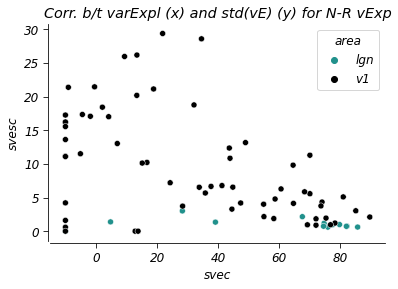

In [2127]:
sns.scatterplot(data=df_only_full, x='svec', y='svesc', hue='area', palette=colors);
plt.title('Corr. b/t varExpl (x) and std(vE) (y) for N-R vExp');

saveName = '06_00a_superposVarExplVar_lgn_v1.pdf'

sns.despine(offset=sns_offset)

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()


In [2128]:
df_only_full.iloc[np.where(np.logical_and(df_only_full['svec']<5, df_only_full['svesc']<5))[0]]


,area,cellType,isSimple,cellNum,f1f0,sfVarExpl,charFreq,prefSf,slope,bwHalf_split,...,auc,auc_std,c50_summ,c50_summ_emp,isFullDisp,threshPass,super_varExpl_clip,svec,c50emp,aucStd
78,lgn,magno,1.000,79,2.710,93.535,2.872,1.329,0.133,1.116,...,0.284,0.006,0.041,0.038,1.000,True,4.763,4.763,0.074,0.006
80,lgn,magno,1.000,81,1.853,nan,nan,nan,nan,nan,...,0.000,0.047,0.000,0.500,1.000,False,-10.000,-10.000,0.400,0.047
66,v1,False,0.000,8,0.624,-2.765,0.122,0.173,-0.083,0.519,...,0.000,0.018,1.500,0.500,1.000,False,-10.000,-10.000,0.078,0.018
79,v1,False,0.000,13,0.180,-389.303,41.968,0.300,0.962,0.000,...,0.000,0.000,1.500,0.500,1.000,False,-10.000,-10.000,0.050,0.000
112,v1,False,0.000,46,0.399,10.079,6.450,5.620,0.000,0.531,...,0.056,0.034,1.500,0.375,1.000,False,-10.000,-10.000,0.153,0.034
118,v1,False,0.000,52,0.126,1.470,8.836,7.444,1.000,nan,...,0.000,0.009,1.500,0.500,1.000,False,-10.000,-10.000,0.050,0.009


### 6.1 Inclusion/exclusion
We excluded all cells which did not have at least 95% of bootstrap repeats with at least _some_ explained variance in the summation (read vExp>0%). What are the properties of those cells versus those without?

Note that this analysis is only relevant for V1, since only 1 LGN cell was exclude:


In [2129]:
df_only_full.groupby(['area', 'threshPass'])['maxResp', 'meanResp', 'oriBW', 'bw34', 'bw34_split',
                                             'bwHalf', 'bwHalf_split', 'c50_pref_emp', 'rfsize', 'rfsize_surr', 
                                             'suprInd', 
                                   'f1f0', 'sfVarExpl', 'isSimple', 'prefSf', 'charFreq'].mean()

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


maxResp  meanResp  oriBW  bw34  bw34_split  bwHalf  \
area threshPass                                                       
lgn  False        34.000    16.205    nan   nan         nan     nan   
     True         39.892    23.376    nan 1.612       2.176   2.612   
v1   False        29.092    12.300 65.211 1.377       0.910   2.176   
     True         50.755    15.363 78.355 1.671       1.011   2.617   

                 bwHalf_split  c50_pref_emp  rfsize  rfsize_surr  suprInd  \
area threshPass                                                             
lgn  False                nan         0.400   0.480        1.770    0.268   
     True               2.644         0.283   0.842        1.610    0.136   
v1   False              1.253         0.386   1.583        4.698    0.455   
     True               1.365         0.309   1.517        3.835    0.424   

                 f1f0  sfVarExpl  isSimple  prefSf  charFreq  
area threshPass                                               
lgn  False      1.853        nan     1.000     nan       nan  
     True       1.857     79.248     1.000   0.674     2.843  
v1   False      0.723     46.509     0.233   2.697     5.760  
     True       0.955     86.016     0.394   2.289     4.745

It seems that the failed V1 cells have a substantially lower maximum firing rate, show less surround suppression, and show a much lower explained variance for single grating SF tuning at high contrast.

Let's test this statistically:



In [2130]:
df_only_full_v1 = df_only_full[df_only_full['area']=='v1']

In [2131]:
df_only_full_v1.groupby(['isSimple'])['threshPass'].value_counts()

isSimple  threshPass
0.000     False         23
          True          20
1.000     True          13
          False          7
Name: threshPass, dtype: int64

In [2132]:
df_only_full_v1[df_only_full_v1['isSimple']==1][['threshPass', 'cellNum', 'auc', 'maxResp']]

,threshPass,cellNum,auc,maxResp
69,True,3,0.895,21.600
70,True,4,0.868,24.900
73,True,7,0.866,25.900
75,False,9,0.483,16.600
76,True,10,1.234,37.900
77,False,11,0.386,44.800
78,True,12,1.143,30.800
80,True,14,0.567,20.300
81,True,15,0.692,22.500
82,True,16,0.802,13.900


In [2133]:
to_test = ['maxResp', 'meanResp', 'oriBW', 'tfBW', 'bw34', 'bw34_split', 'bwHalf', 'bwHalf_split', 'c50_pref_emp', 'suprInd', 
                                   'f1f0', 'sfVarExpl', 'isSimple', 'charFreq', 'prefSf']

# optionally, test this for ONLY simple or ONLY complex (change)
testSimple = 0; # 1/-1/0 for only simple, onlly complex, or all

for fld in to_test:
    if testSimple == 1:
        valz = (*df_only_full_v1[df_only_full_v1['isSimple']==1].groupby(['threshPass'])[fld].apply(list), )
    elif testSimple == -1:
        valz = (*df_only_full_v1[df_only_full_v1['isSimple']==0].groupby(['threshPass'])[fld].apply(list), )
    else:
        valz = (*df_only_full_v1.groupby(['threshPass'])[fld].apply(list), )
    ncells = [len(x) for x in valz]
    tst_t = ss.ttest_ind(*valz, nan_policy='omit')
    tst_k = ss.ks_2samp(*valz, )
    
    print('%s %.2f[%d] vs %.2f[%d]: \n\tp=%.2e [t]\n\tp=%.2e [ks]' % (fld, np.nanmean(valz[0]), ncells[0], 
                                                  np.nanmean(valz[1]), ncells[1], tst_t.pvalue, tst_k.pvalue))

maxResp 29.09[30] vs 50.75[33]: 
	p=1.99e-02 [t]
	p=3.44e-01 [ks]
meanResp 12.30[30] vs 15.36[33]: 
	p=3.05e-01 [t]
	p=9.54e-01 [ks]
oriBW 65.21[30] vs 78.35[33]: 
	p=2.20e-01 [t]
	p=2.74e-01 [ks]
tfBW 1.75[30] vs 2.64[33]: 
	p=5.13e-02 [t]
	p=1.64e-01 [ks]
bw34 1.38[30] vs 1.67[33]: 
	p=7.64e-02 [t]
	p=3.75e-01 [ks]
bw34_split 0.91[30] vs 1.01[33]: 
	p=7.41e-01 [t]
	p=1.25e-01 [ks]
bwHalf 2.18[30] vs 2.62[33]: 
	p=1.09e-01 [t]
	p=5.72e-01 [ks]
bwHalf_split 1.25[30] vs 1.36[33]: 
	p=7.45e-01 [t]
	p=5.94e-01 [ks]
c50_pref_emp 0.39[30] vs 0.31[33]: 
	p=1.37e-01 [t]
	p=1.73e-01 [ks]
suprInd 0.45[30] vs 0.42[33]: 
	p=7.24e-01 [t]
	p=7.56e-01 [ks]
f1f0 0.72[30] vs 0.96[33]: 
	p=7.92e-02 [t]
	p=3.52e-02 [ks]
sfVarExpl 46.51[30] vs 86.02[33]: 
	p=1.56e-02 [t]
	p=1.01e-04 [ks]
isSimple 0.23[30] vs 0.39[33]: 
	p=1.77e-01 [t]
	p=7.40e-01 [ks]
charFreq 5.76[30] vs 4.75[33]: 
	p=4.91e-01 [t]
	p=9.43e-01 [ks]
prefSf 2.70[30] vs 2.29[33]: 
	p=4.68e-01 [t]
	p=4.27e-01 [ks]


##### So, the excluded cells have a statistically lower maxResp and lower explained variance of SF tuning at high contrast; there is no difference in mean response, oriBw, bw34, c50, suprInd

*Note: The default for all below plots should be only included cells*



### 6.1a

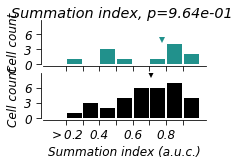

In [2134]:
subset_full = False;
# if true, then plot for all
# if false, then only those that pass

# specs
halfsz = True;
noLgnd = True;
scale = 0.45 if halfsz else 1

saveName = '06_01_AUC_lgn_v1_%s%s%s.pdf' % ('full' if subset_full else 'pass', '_noLgnd' if noLgnd else '', '_halfSz' if halfsz else '')

which_data = df_only_full if subset_full else df_only_pass;

ars = df['area'].unique();

nrow,ncol=2,1
f, ax = plt.subplots(nrow,ncol,figsize=hf.set_size(scale*tex_width),# extra_height=1./scale), 
                 sharey=True, sharex=True);

# clipLow = -10
# clipHigh = None;
kywrd = 'auc'
use_norm = False;

# bins for sfErr metric
bins = np.linspace(0.1, 1, 10)
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;
width = hist_width*stepSize;

for (plt_i, (name,group)), clr in zip(enumerate(which_data.groupby('area')), colors):
    
    vls = group[kywrd].values;
    clipped = np.clip(vls, clipLow, clipHigh);
    vals, _ = np.histogram(clipped, bins=bins)
    vals_norm = vals/np.sum(vals)
    
    to_use = vals_norm if use_norm else vals;
    
    ax[plt_i].bar(binPlotLocs, to_use, width=width, align='center', color=clr,
                 label='%s [n=%d, mdn=%.2f]' % (name.upper(), len(vls), np.nanmedian(vls)));
    
    tickStrs = ['%.1f' % x for x in tickVals];
    tickStrs[0] = '$>$%s' % tickStrs[0];
    tickStrs[-1] = '$<$%s' % tickStrs[-1];
    if halfsz: # take out every other...
        tickStrs = [str_val if np.mod(str_i,2)==0 else '' for str_i,str_val in enumerate(tickStrs)]
    ax[plt_i].set_xticks(tickVals);
    ax[plt_i].set_xticklabels(tickStrs);
    ax[plt_i].plot(np.nanmedian(vls), 1.2*np.nanmax(to_use), 'v', color=clr)
#     ax[plt_i].set_title('%s: mdn=%.2e [n=%d]' % (area.upper(), np.nanmedian(vls), len(vls)))

    if not noLgnd:
        ax[plt_i].legend();
    ax[plt_i].set_ylabel('Fraction of cells' if use_norm else 'Cell count');
    if plt_i==nrow-1:
        ax[plt_i].set_xlabel('Summation index (a.u.c.)');

    for jj, axis in enumerate([ax[plt_i].xaxis, ax[plt_i].yaxis]):
        if jj==1: # i.e. y axis, make sure we have tick labels, here, too
            from matplotlib.ticker import MaxNLocator
            axis.set_major_locator(MaxNLocator(3, integer=True))

        
sns.despine(offset=sns_offset)
ttest = ss.ttest_ind(*which_data.groupby('area')['auc'].apply(list),)
f.suptitle('Summation index, p=%.2e' % (ttest.pvalue))

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

In [2135]:
#### Any difference by cell type (note that False is complex, True is simple for V1)??
df_only_pass.groupby(['cellType'])['auc'].agg(['count', 'median'])

,count,median
cellType,,
False,20,0.633
True,13,0.802
magno,3,0.496
other,2,0.661
parvo,7,0.896


Looks like parvos are more linear than magnos; and simples are more linear than complex. Can we test the latter statistically?

In [2136]:
smp,cmp = df_only_pass[df_only_pass['area']=='v1'].groupby(['cellType'])['auc'].apply(list)
ss.ttest_ind(smp, cmp)

Ttest_indResult(statistic=-1.802287007096838, pvalue=0.08123174609352035)

*No statistical difference in AUC for simple and complex cells in V1*

### 6.2 Compare sfVar metric between LGN, V1 for included cells



In [2137]:
df_only_full.keys()

Index(['area', 'cellType', 'isSimple', 'cellNum', 'f1f0', 'sfVarExpl',
       'charFreq', 'prefSf', 'slope', 'bwHalf_split', 'bwHalf', 'bw34_split',
       'bw34', 'rfsize', 'rfsize_surr', 'suprInd', 'oriBW', 'tfBW', 'tfPref',
       'meanResp', 'mdnResp', 'maxResp', 'c50_pref', 'c50_pref_emp', 'sfErrs',
       'sfErrsBootStd', 'sfErrsBootMdn', 'super_varExpl', 'super_varExpl_std',
       'svesc', 'auc', 'auc_std', 'c50_summ', 'c50_summ_emp', 'isFullDisp',
       'threshPass', 'super_varExpl_clip', 'svec', 'c50emp', 'aucStd'],
      dtype='object')

In [2138]:
df_only_full[['area', 'cellNum', 'super_varExpl']].head(10)

,area,cellNum,super_varExpl
40,lgn,41,67.542
42,lgn,43,82.163
44,lgn,45,75.883
50,lgn,51,74.660
52,lgn,53,77.411
53,lgn,54,79.710
69,lgn,70,85.630
71,lgn,72,74.478
76,lgn,77,39.097
77,lgn,78,28.276


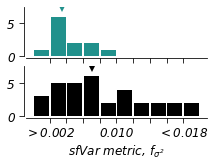

In [2139]:
subset_full = False;
# if true, then plot for all
# if false, then only those that pass

# specs
halfsz = True
noLgnd = True;
scale = 0.5 if halfsz else 1

saveName = '06_02_sfVarMetric_lgn_v1_%s%s%s.pdf' % ('full' if subset_full else 'pass', '_noLgnd' if noLgnd else '', '_halfSz' if halfsz else '')

which_data = df_only_full if subset_full else df_only_pass;

# temp...
# err, errStd = np.transpose(which_data[['sfErrs', 'sfErrsBootStd']].dropna().values, )
# cutoff = 1.5*np.max(which_data[which_data['area']=='lgn']['sfErrsBootStd'].values)#np.nanpercentile(errStd, 75)
# which_data = which_data[which_data['sfErrsBootStd']<=cutoff]; # filter out some extreme values

ars = df['area'].unique();

nrow,ncol=2,1
f, ax = plt.subplots(nrow,ncol,figsize=hf.set_size(scale*tex_width), sharey=True, sharex=True);

kywrd = 'sfErrs'
# kywrd = 'sfErrsBootMdn'
use_norm = False;

# bins for sfErr metric
bins = np.linspace(0, 0.02, 11)
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;
width = hist_width*stepSize;

for (plt_i, (name,group)), clr in zip(enumerate(which_data.groupby('area')), colors):
    
    vls = group[kywrd].values;
    clipped = np.clip(vls, clipLow, clipHigh);
    vals, _ = np.histogram(clipped, bins=bins)
    vals_norm = vals/np.sum(vals)
    
    to_use = vals_norm if use_norm else vals;
    
    ax[plt_i].bar(binPlotLocs, to_use, width=width, align='center', color=clr,
                 label='%s [n=%d, mdn=%.1e]' % (name.upper(), len(vls), np.nanmedian(vls)));
    
    ax[plt_i].plot(np.nanmedian(vls), 1.2*np.nanmax(to_use), 'v', color=clr)
    tickStrs = ['%.3f' % x for x in tickVals];
    tickStrs[0] = '$>$%s' % tickStrs[0];
    tickStrs[-1] = '$<$%s' % tickStrs[-1];
    if halfsz: # take out every other...
        tickStrs = [str_val if np.mod(str_i,4)==0 else '' for str_i,str_val in enumerate(tickStrs)]
    ax[plt_i].set_xticks(tickVals);
    ax[plt_i].set_xticklabels(tickStrs);
#     ax[plt_i].set_title('%s: mdn=%.2e [n=%d]' % (area.upper(), np.nanmedian(vls), len(vls)))

    if not noLgnd:
        ax[plt_i].legend();
#     ax[plt_i].set_ylabel('Fraction of cells' if use_norm else 'Cell count');
    if plt_i==nrow-1:
        ax[plt_i].set_xlabel(r'sfVar metric, $f_{\sigma^2}$');

sns.despine(offset=sns_offset)
tst = ss.ttest_ind(*which_data.groupby('area')[kywrd].apply(list),)
# f.suptitle('Comparing sfVar by area [p=%.3f]' % tst.pvalue)

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

##### Pop. difference between LGN and V1!
*However, what if we compare LGN to just simple or just complex?*

In [2140]:
kywrd = 'sfErrsBootMdn'
# kywrd = 'sfErrs'

lgn_onlypass = df_only_pass[df_only_pass['area']=='lgn']
v1_onlypass = df_only_pass[df_only_pass['area']=='v1']

lgn_vals = lgn_onlypass[kywrd].values
smp_vals = v1_onlypass[v1_onlypass['isSimple']==True][kywrd].values
cmp_vals = v1_onlypass[v1_onlypass['isSimple']==False][kywrd].values

tst_vSimp = ss.ttest_ind(lgn_vals, smp_vals)
tst_vComp = ss.ttest_ind(lgn_vals, cmp_vals)
tst_compVsimp = ss.ttest_ind(smp_vals, cmp_vals)

print('Simple (p=%.4f) and complex (p=%.4f) %s distributions compared to LGN distr.]' % (tst_vSimp.pvalue, tst_vComp.pvalue, kywrd))
print('\tSimple (mdn=%.2e) vs. complex (mdn=%.2e) gives p=%.4f' % (np.median(smp_vals), np.median(cmp_vals), tst_compVsimp.pvalue))

Simple (p=0.1969) and complex (p=0.0013) sfErrsBootMdn distributions compared to LGN distr.]
	Simple (mdn=5.00e-03) vs. complex (mdn=9.56e-03) gives p=0.0260


##### Any difference between simple & complex with sfVar?

Again, note that simple is True, complex is False belo

In [2141]:
df_only_pass[df_only_pass['area']=='v1'].groupby(['cellType'])['sfErrs'].agg(['mean', 'median', 'count'])

,mean,median,count
cellType,,,
False,0.010,0.009,20
True,0.006,0.005,13


In [2142]:
df_only_pass[df_only_pass['area']=='v1'].groupby(['cellType'])['sfErrs'].agg(['mean', 'median', 'count'])

,mean,median,count
cellType,,,
False,0.010,0.009,20
True,0.006,0.005,13


In [2143]:
smp,cmp = df_only_pass[df_only_pass['area']=='v1'].groupby(['cellType'])['sfErrs'].apply(list)
ss.ttest_ind(smp, cmp)

Ttest_indResult(statistic=2.209907826609766, pvalue=0.034626270524295906)

##### What about the variance of this metric? Any relationship between sfVar and its reliability?
We want to make sure that large sfVar values aren't just more variable!



In [2144]:
# valz = np.transpose(which_data[[metr_a, metr_b]].dropna().values, )

In [2145]:
# ss.pearsonr(err, np.log(errStd))

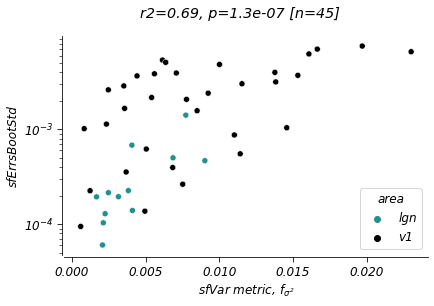

In [2146]:
subset_full = False;
# if true, then plot for all
# if false, then only those that pass

halfsz = True;

scale = 0.5 if halfsz else 1

whichErr = 'sfErrs' # the one off value?
# whichErr = 'sfErrsBootMdn' # or the boot strapped median?

saveName = '06_02a_sfVarMetric_stability_lgn_v1_%s%s.pdf' % ('full' if subset_full else 'pass', 'halfSz' if halfsz else '')

err, errStd = np.transpose(which_data[[whichErr, 'sfErrsBootStd']].dropna().values, )

cutoff = np.nanpercentile(errStd, 75)

which_data = df_only_full if subset_full else df_only_pass;
# which_data = which_data[which_data['sfErrs']<0.15]; # filter out some extreme values
# which_data = which_data[which_data['sfErrsBootStd']<cutoff]; # filter out some extreme values

f = plt.figure(figsize=hf.set_size(tex_width));
sns.scatterplot(data=which_data, x=whichErr, y='sfErrsBootStd', hue='area', palette=colors);
# plt.yscale('log')
r2,p,n = pearson_r_pandas(which_data, whichErr, 'sfErrsBootStd')
f.suptitle('r2=%.2f, p=%.1e [n=%d]' % (r2,p,n));
sns.despine(offset=sns_offset)
plt.xlabel(r'sfVar metric, $f_{\sigma^2}$')

plt.yscale('log')

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

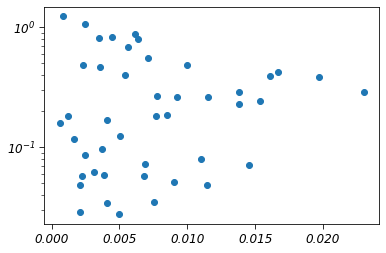

In [2147]:
# however, if we norm. the std (errStd) by the metric (err), things look more lawful...? 
plt.scatter(err, errStd/err)
plt.yscale('log')

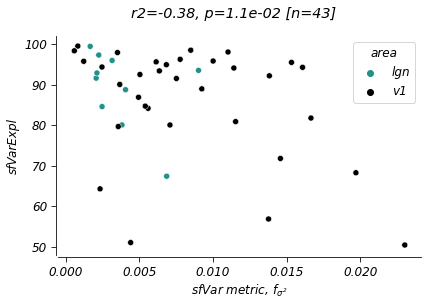

In [2148]:
subset_full = False;
# if true, then plot for all
# if false, then only those that pass

saveName = '06_02b_sfVarMetric_stability_alt_lgn_v1_%s.pdf' % ('full' if subset_full else 'pass')

whichErr = 'sfErrs'
# whichErr = 'sfErrsBootMdn'

err, errStd = np.transpose(which_data[[whichErr, 'sfVarExpl']].dropna().values, )

which_data = df_only_full if subset_full else df_only_pass;
# throw out one value odd value
which_data = which_data[which_data['sfVarExpl']>0]; # filter out some extreme values
# which_data = which_data[which_data['sfErrsBootStd']<cutoff]; # filter out some extreme values

f = plt.figure(figsize=hf.set_size(tex_width));
sns.scatterplot(data=which_data, x=whichErr, y='sfVarExpl', hue='area', palette=colors);
# plt.yscale('log')
r2,p,n = pearson_r_pandas(which_data, whichErr, 'sfVarExpl')
f.suptitle('r2=%.2f, p=%.1e [n=%d]' % (r2,p,n));
sns.despine(offset=sns_offset)
plt.xlabel(r'sfVar metric, $f_{\sigma^2}$')

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

**Both of the above plots show that this metric might be problematic!**

While it shows hints of reflecting some frequency-dependent process, the measure is too correlated with noise to be trusted. Namely, the sfErr metric has systematically higher variance across bootstrap repititions for higher value sfErrs!


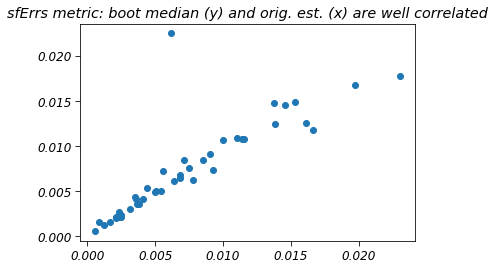

In [2149]:
aa,bb = np.transpose(which_data[['sfErrs', 'sfErrsBootMdn']].dropna().values, )
plt.scatter(aa,bb);
plt.title('sfErrs metric: boot median (y) and orig. est. (x) are well correlated');


### 6.3 For cells that pass, what are some tuning differences between LGN and V1?



In [2150]:
df_only_pass.groupby('area')['maxResp', 'meanResp', 'oriBW', 'tfBW', 'tfPref', 'bw34', 'bw34_split', 'c50_pref_emp', 'rfsize', 'rfsize_surr', 'suprInd', 
                                   'f1f0', 'sfVarExpl', 'isSimple', 'charFreq', 'prefSf'].mean()

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,maxResp,meanResp,oriBW,tfBW,tfPref,bw34,bw34_split,c50_pref_emp,rfsize,rfsize_surr,suprInd,f1f0,sfVarExpl,isSimple,charFreq,prefSf
area,,,,,,,,,,,,,,,,
lgn,39.892,23.376,nan,2.859,14.824,1.612,2.176,0.283,0.842,1.610,0.136,1.857,79.248,1.000,2.843,0.674
v1,50.755,15.363,78.355,2.637,9.234,1.671,1.011,0.309,1.517,3.835,0.424,0.955,86.016,0.394,4.745,2.289


In [2151]:
use_all_data = False;
which_data = df if use_all_data else df_only_pass

to_test = ['maxResp', 'meanResp', 'oriBW', 'tfPref', 'bw34', 'bw34_split', 'bwHalf_split', 'c50_pref_emp', 'suprInd', 
                                   'f1f0', 'sfVarExpl', 'prefSf', 'charFreq', 'tfBW']
for fld in to_test:
    valz = (*which_data.groupby('area')[fld].apply(list), )
    ncells = [len(hf.nan_rm(np.array(x))) for x in valz]
    tst_t = ss.ttest_ind(*valz, nan_policy='omit')
    tst_k = ss.ks_2samp(*valz, )
    
    print('%s %.2f[%d] vs %.2f[%d]: \n\tp=%.2e [t]\n\tp=%.2e [ks]' % (fld, np.nanmean(valz[0]), ncells[0], 
                                                  np.nanmean(valz[1]), ncells[1], tst_t.pvalue, tst_k.pvalue))

maxResp 39.89[12] vs 50.75[33]: 
	p=4.47e-01 [t]
	p=6.02e-01 [ks]
meanResp 23.38[12] vs 15.36[33]: 
	p=8.61e-02 [t]
	p=4.37e-03 [ks]
oriBW nan[0] vs 78.35[33]: 
	p=nan [t]
	p=6.95e-11 [ks]
tfPref 14.82[12] vs 9.23[33]: 
	p=1.78e-02 [t]
	p=2.99e-01 [ks]
bw34 1.61[4] vs 1.67[28]: 
	p=8.46e-01 [t]
	p=1.17e-02 [ks]
bw34_split 2.18[11] vs 1.01[32]: 
	p=1.50e-02 [t]
	p=2.13e-02 [ks]
bwHalf_split 2.64[11] vs 1.36[32]: 
	p=1.33e-02 [t]
	p=3.23e-02 [ks]
c50_pref_emp 0.28[12] vs 0.31[33]: 
	p=6.68e-01 [t]
	p=3.29e-01 [ks]
suprInd 0.14[12] vs 0.42[33]: 
	p=7.36e-03 [t]
	p=6.16e-03 [ks]
f1f0 1.86[12] vs 0.96[33]: 
	p=2.09e-06 [t]
	p=1.51e-07 [ks]
sfVarExpl 79.25[11] vs 86.02[33]: 
	p=3.51e-01 [t]
	p=9.70e-01 [ks]
prefSf 0.67[11] vs 2.29[33]: 
	p=1.30e-02 [t]
	p=9.94e-03 [ks]
charFreq 2.84[11] vs 4.75[33]: 
	p=8.17e-02 [t]
	p=1.86e-01 [ks]
tfBW 2.86[7] vs 2.64[21]: 
	p=7.09e-01 [t]
	p=7.12e-01 [ks]


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:1070: RuntimeWarning: divide by zero encountered in true_divide
  denom = ma.sqrt(svar*(1.0/n1 + 1.0/n2))  # n-D computation here!
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Warning: converting a masked element to nan.
  del sys.path[0]


##### So, there is a marked difference between LGN and V1 in terms of:
- bandwidth on the high spatial frequency limb (more measurable than total bandwidth, often undefined for LGN cells)
    - LGN more broadly tuned than V1, of course
- suppression index (for rfSize experiment)
    - LGN less surround suppressed than V1

*Let's look first if it those two metrics are correlated with one another in our dataset:*


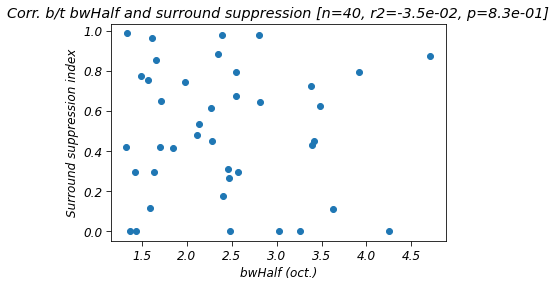

In [2156]:
useBwHalf = True;
all_v1_data = False; # if all V1, then include even cells which don't have full superpos. experiment
df_all_v1 = df[df['area']=='v1']

bwStr = 'bwHalf' if useBwHalf else 'bw34';
use_data = df_all_v1 if all_v1_data else df_only_full_v1

bwHalf, bw34, bw34_split, suprInd = (*np.transpose(use_data[['bwHalf', 'bw34', 'bw34_split', 'suprInd']].values), )

which_bw = bwHalf if useBwHalf else bw34;

plt.scatter(which_bw, suprInd)
nn = np.logical_and(~np.isnan(which_bw), ~np.isnan(suprInd))
oh = ss.linregress(which_bw[nn], suprInd[nn])
plt.xlabel('%s (oct.)' % bwStr)
plt.ylabel('Surround suppression index')
plt.title('Corr. b/t %s and surround suppression [n=%d, r2=%.1e, p=%.1e]' % (bwStr, np.sum(nn), oh.rvalue, oh.pvalue));


Regardless of whether we include all V1 data or only those that have a full superposition experiment, **there is no correlation between surround suppression index and spatial frequency bandwidth.**Tr

So, one way of digging deeper into this dataset is to see if the subset of V1 neurons that are more LGN like (whether lower surround suppression or more broadly tuned) are more LGN-like. We can check that below


In [2157]:
# area = 'v1'
area = 'lgn'
pearson_r_pandas(df_only_pass[df_only_pass['area']==area], 'sfErrs', 'sfVarExpl')
# or all together
# pearson_r_pandas(df_only_pass, 'sfErrs', 'charFreq')

(-0.15748888022629703, 0.6437473517811355, 11)

In [2041]:
df_only_pass.groupby('area').corr()['sfErrs']

area                    
lgn   isSimple                nan
      cellNum               0.487
      f1f0                  0.442
      sfVarExpl            -0.157
      charFreq             -0.089
                            ...  
v1    threshPass              nan
      super_varExpl_clip   -0.415
      svec                 -0.415
      c50emp               -0.080
      aucStd               -0.151
Name: sfErrs, Length: 76, dtype: float64

In [2042]:
to_use = df_only_full_v1[df_only_full_v1['threshPass']]
print(to_use.groupby('isSimple')['threshPass'].count())
print(df_all_v1.groupby('isSimple')['threshPass'].count())

isSimple
0.000    20
1.000    13
Name: threshPass, dtype: int64
isSimple
0.000    122
1.000     48
Name: threshPass, dtype: int64


Of the 33 passed V1 cells, 20 (\~60% are complex) and 13 are simple; this is actually an overrepresentation of simple cells (\~72% complex in full population)


### 6.4 Relationship between mixture summation metrics and other metrics!

Adjust which_exp_code to make these plots for LGN, V1, or both together

In [2166]:
which_exp_code = 1; # 0 for LGN, 1 for V1, 2 for both

if which_exp_code==0: # lgn
    which_exp = 'LGN'
    which_data_curr = df_only_pass[df_only_pass['area']=='lgn']
    which_colors = colors[0]
elif which_exp_code==1: # v1
    which_exp = 'V1'
    which_colors = colors[1]
    which_data_curr = df_only_pass[df_only_pass['area']=='v1']
else:
    which_colors = colors;
    which_exp = 'both'
    which_data_curr = df_only_pass

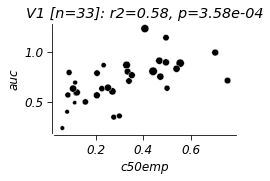

In [2167]:
y = 'auc'
x = 'c50emp'

# x = 'auc'
# y = 'sfErrs'


# specs
halfsz = True;
scale = 0.5 if halfsz else 1

saveName = '06_04a_summation_%s_vs_%s_%s%s.pdf' % (x,y,which_exp, '_halfSz' if halfsz else '')

f = plt.figure(figsize=hf.set_size(scale*tex_width))

if which_exp_code==2:
    sns.scatterplot(data=which_data_curr, x=x, y=y, hue='area', size='aucStd', legend=False, palette=which_colors);
else: # no hue spec
    sns.scatterplot(data=which_data_curr, x=x, y=y, size='aucStd', color=which_colors, legend=False, palette=which_colors);
r2, p, n = pearson_r_pandas(which_data_curr, x, y);
plt.xlabel(x);
plt.ylabel(y);
plt.title('%s [n=%d]: r2=%.2f, p=%.2e' % (which_exp, n, r2, p))
sns.despine(offset=sns_offset)

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

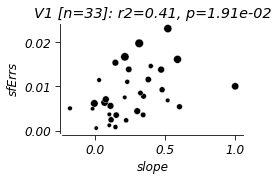

In [2168]:
# x = 'suprInd'
# y = 'sfErrs'

x = 'slope'

# x = 'tfPref'
# x = 'prefSf'
# y = 'sfErrs'
# y = 'slope'

# x = 'bwHalf'
y = 'sfErrs'

# specs
halfsz = True;
scale = 0.5 if halfsz else 1

saveName = '06_04b_%s_vs_%s%s%s.pdf' % (x, y, which_exp, '_halfSz' if halfsz else '')

f = plt.figure(figsize=hf.set_size(scale*tex_width))

if which_exp_code==2:
    sns.scatterplot(data=which_data_curr, x=x, y=y, hue='area', size='sfErrsBootStd', legend=False, palette=which_colors);
else: # no hue spec
    sns.scatterplot(data=which_data_curr, x=x, y=y, size='sfErrsBootStd', color=which_colors, legend=False, palette=which_colors);
r2, p, n = pearson_r_pandas(which_data_curr, x, y);
plt.xlabel(x);
plt.ylabel(y);
plt.title('%s [n=%d]: r2=%.2f, p=%.2e' % (which_exp, n, r2, p))
sns.despine(offset=sns_offset)

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

### 6.5 Breaking down V1 by higher/lower suprInd and bandwidth

Adjust SuprInd/Above from 0 and 1 (thus 4 possible plots below)

In [314]:
# starting with only V1
splitSuprInd = 0; # 1 for suprInd, 0 for bw
splitAbove = 0; # 1 for higher values, 0 for lower values

splitStr = 'bw' if splitSuprInd==0 else 'suprInd'
splitStr = '%s%s' % (splitStr, 'Higher' if splitAbove==1 else 'Lower')

ky = 'suprInd' if splitSuprInd==1 else 'bw34';

which_data_curr = df_only_pass[df_only_pass['area']=='v1']
cutoff = np.nanpercentile(df_only_pass[ky], 50)
if splitAbove==1:
    which_data_curr = which_data_curr[which_data_curr[ky]>=cutoff]
else:
    which_data_curr = which_data_curr[which_data_curr[ky]<cutoff]


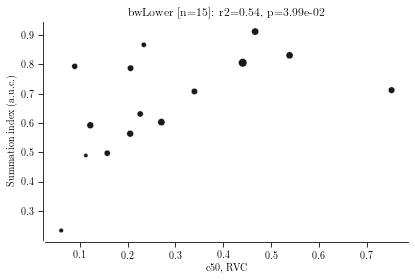

In [315]:
x = 'c50emp'
y = 'auc'

saveName = '06_05a_summation_grat_v_mix_v1_%s.pdf' % (splitStr)

f = plt.figure(figsize=hf.set_size(tex_width))

sns.scatterplot(data=which_data_curr, x=x, y=y, size='aucStd', legend=False, color='k');
r2, p, n = pearson_r_pandas(which_data_curr, x, y);
plt.xlabel('c50, RVC');
plt.ylabel('Summation index (a.u.c.)');
plt.title('%s [n=%d]: r2=%.2f, p=%.2e' % (splitStr, n, r2, p))
sns.despine(offset=sns_offset)

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

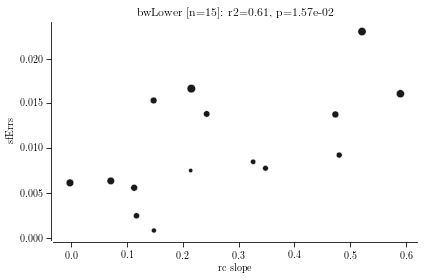

In [316]:
x = 'slope'
y = 'sfErrs'

saveName = '06_05b_summation_grat_v_mix_%s.pdf' % (splitStr)

f = plt.figure(figsize=hf.set_size(tex_width))

sns.scatterplot(data=which_data_curr, x=x, y=y, size='sfErrsBootStd', legend=False, color='k');
r2, p, n = pearson_r_pandas(which_data_curr, x, y);
plt.xlabel('rc slope');
plt.ylabel('sfErrs');
plt.title('%s [n=%d]: r2=%.2f, p=%.2e' % (splitStr, n, r2, p))
sns.despine(offset=sns_offset)

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

# 2. Masks (Bauman + Bonds)

In [2073]:
params = {'text.usetex' : False,
          'font.size' : fontsz,
          'font.family': 'lmodern',
           'font.style': 'italic'}
plt.rcParams.update(params)

In [2074]:
analysis_date = '230125' # 23 was the standard
sfBB = hf.np_smart_load('V1_BB/structures/sfBB_analysis_%s.npy' % analysis_date)
v1 = hf.np_smart_load('jointList_wMods_V1_230121vE_vT00_dvT00_m3j10.npy')

nCells = len(sfBB.keys())

# get some measures that are easier to do directly from the jointList
slps = -hf.jl_get_metric_byCon(v1, 'dog_mod_slope', conVal=None, disp=0)[0]
dog_bwHalf_hiCon = hf.jl_get_metric_byCon(v1, metric='dog_bwHalf', conVal=1, disp=0)[0]
dog_bw34_hiCon = hf.jl_get_metric_byCon(v1, metric='dog_bw34', conVal=1, disp=0)[0]
mn_med_max = hf.jl_get_metric_byCon(v1, 'mn_med_max', conVal=None, disp=None)[0]
mn, md, mx = np.transpose(mn_med_max);

In [2075]:
respStr_print = lambda x: 'simple' if x==1 else 'complex'

In [2076]:
# create the sfBB-only subset of the jointList (v1)
ohno = pd.DataFrame.from_dict(v1)
meta = pd.json_normalize([ohno[x]['metadata'] for x in sorted(ohno.keys())])
metr = pd.json_normalize([ohno[x]['metrics'] for x in sorted(ohno.keys())])
modl = pd.json_normalize([ohno[x]['model'] for x in sorted(ohno.keys())])
# supr = pd.json_normalize([ohno[x]['superpos'] for x in sorted(ohno.keys())])
basc = pd.json_normalize([ohno[x]['basics'] for x in sorted(ohno.keys())])

v1_pd = pd.concat((meta, metr, modl, basc), axis=1);
is_BB = ['BB' in x for x in v1_pd['fullPath']]
# take only the BB cells
v1_bb_pd = v1_pd.iloc[is_BB]
# keep the index into the overall jointlist...
v1_bb_pd['jl_index']= v1_bb_pd.index
# ...but make the index the BB-only cellNum
v1_bb_pd.set_index('cellNum', inplace=True)
v1_bb_pd['respMeasurePrint'] = v1_bb_pd['respMeasure'].apply(respStr_print)

# now put those measures here...
v1_bb_pd['dog_bwHalf_hiCon'] = dog_bwHalf_hiCon[is_BB]
v1_bb_pd['dog_bw34_hiCon'] = dog_bw34_hiCon[is_BB]
v1_bb_pd['meanResp'] = mn[is_BB]
v1_bb_pd['medianResp'] = md[is_BB]
v1_bb_pd['maxResp']= mx[is_BB]

which_respMeasure = v1_bb_pd.respMeasure;
which_respStr = [hf_sfBB.get_resp_str(x) for x in which_respMeasure]

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [2077]:
# added on 23.01.26 --> was this cell targeted for recording?
# --- the majority were, so default to yes
v1_bb_was_targeted = np.ones((nCells, ), dtype='bool');
# then, fill in which ones were NOT (i.e. were instead picked up from sorting)
sort_cell_nums = np.array([26, 28, 29, 30, 32, 33, 34, 35, 37, 38, 41, 43, 45])
v1_bb_was_targeted[sort_cell_nums-1] = 0;

n_targets = np.sum(v1_bb_was_targeted)
print('%d out of %d total cells were targeted; thus %d were picked up from sorting' % (n_targets, nCells, nCells-n_targets))

34 out of 47 total cells were targeted; thus 13 were picked up from sorting


In [2078]:
v1_bb_pd['wasTarget'] = v1_bb_was_targeted;

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [2079]:
sfBB_pd = pd.DataFrame.from_dict(sfBB, orient='index')
sfBB_pd.rename(columns={'f1f0_ratio': 'f1f0_ratio_notJL'}, inplace=True)
dcs = pd.json_normalize(sfBB_pd['dc'])
sfBB_pd.drop('dc', axis=1, inplace=True)
f1s = pd.json_normalize(sfBB_pd['f1'])
f1s.rename(columns={'baseResp_circVar': 'baseVarEst'}, inplace=True)
sfBB_pd.drop('f1', axis=1, inplace=True)
# first rename so that we can create one df with both DC and F1 values
dcs_rename = dcs.rename(columns = {x: 'dc_%s' % x for x in dcs.columns}, inplace = False)
f1s_rename = f1s.rename(columns = {x: 'f1_%s' % x for x in f1s.columns}, inplace = False)
sfBB_pd_all = pd.concat([sfBB_pd, dcs, f1s], axis=1, ignore_index=True)
sfBB_pd_all.insert(0, 'cellNum', range(1,1+nCells))
sfBB_pd_all.set_index('cellNum', inplace=True)
sfBB_pd_all.rename(columns={'sfVarExpl': 'sfVarExpl_hiCon'}, inplace=True)
# now, go through and grab DC/F1, correspondingly
# --- first, add the independent-of-respMeasure stuff (sfBB_pd after dropping 'dc'/'f1' fields)
# --- and add cellNum index so that we can join properly
sfBB_pd.insert(0, 'cellNum', range(1,1+nCells))
sfBB_pd.set_index('cellNum', inplace=True)
sfBB_pd_correct = pd.concat([v1_bb_pd, sfBB_pd], axis=1);
# --- now add the correct measure (start by just copying the DC) 
# ______ NOTE: just a subset of all keys ()
corr_subset = dcs[['baseDiffs', 'sfPref', 'charFreq', 'sfVarExpl', 'baseResp_mean', 'baseResp_std', 'baseResp_fano']].copy()
# we'll rename the baseResp_std column to represent variance of the base response generally
# --- for F1, this will be the circular variance of the response phase
corr_subset.rename(columns={'baseResp_fano': 'baseVarEst'}, inplace=True)
for iii, respMeasure in enumerate(which_respMeasure):
    if respMeasure==1: # i.e F1, then we need to overwrite
        corr_subset.iloc[iii] = f1s[['baseDiffs', 'sfPref', 'charFreq', 'sfVarExpl', 'baseResp_mean', 'baseResp_std', 'baseVarEst']].iloc[iii]
corr_subset.insert(0, 'cellNum', range(1,1+nCells))
corr_subset.set_index('cellNum', inplace=True)
corr_subset.rename(columns={'sfVarExpl': 'sfVarExpl_hiCon'}, inplace=True)
df_subset = pd.concat([sfBB_pd_correct, corr_subset], axis=1)
df_subset['maskSf_relPref'] = df_subset['maskSf']/df_subset['sfPref']
# what percentage of the max. response was the base stimulus?
df_subset['baseAsMaxFrac'] = df_subset['baseResp_mean']/v1_bb_pd['maxResp']
df_subset['baseAsMeanFrac'] = df_subset['baseResp_mean']/v1_bb_pd['meanResp']

df_all = pd.concat([sfBB_pd_correct, sfBB_pd_all], axis=1)

<AxesSubplot:xlabel='baseResp_mean', ylabel='baseResp_std'>

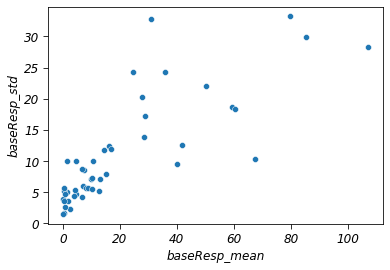

In [2080]:
sns.scatterplot(data=df_subset, x='baseResp_mean', y='baseResp_std')

In [2081]:
dcs.keys()

Index(['blank_mean', 'blank_std', 'blank_stderr', 'bothResp', 'maskResp',
       'baseResp_all', 'baseResp_mean', 'baseResp_std', 'baseResp_fano',
       'baseResp_stderr', 'diffFromSumResp', 'baseDiffs', 'sfPref_est',
       'sfPref', 'charFreq', 'sfVarExpl'],
      dtype='object')

In [2082]:
def has_neighbor(threshMatrix, cut_row_zero=False):
    tm_out = np.copy(threshMatrix);
    r_lo, r_hi = 0,threshMatrix.shape[0]-1
    c_lo, c_hi = 0,threshMatrix.shape[1]-1
    if cut_row_zero:
        tm_out[0,:] = 0;
    abv_r, abv_c = np.where(tm_out);
    
    for r,c in zip(abv_r, abv_c):
        neighbor = False;
        # first check x
        for pm in [-1,1]:
            if tm_out[np.clip(r+pm, r_lo, r_hi)][c]==1 and np.clip(r+pm, r_lo, r_hi)!=r:
                neighbor = True
        # then check y, if needed
        if not neighbor:
            for pm in [-1,1]:
                if tm_out[r][np.clip(c+pm, c_lo, c_hi)]==1 and np.clip(c+pm, c_lo, c_hi)!=c:
                    neighbor=True
        # now, if we fidn't find any neighbors...
        if not neighbor:
            tm_out[r,c] = 0; # failed the neighbor check!
            
    return tm_out.astype('bool');

### Organize the data

In [2083]:
suppr_ind = 1; # 0 is raw, 1 is norm. by baseStd, 2 is norm by baseMean
# ---set threshold accordingly
thresh_val = -0.5 if suppr_ind==1 else -0.2;

# set up some places to store values
hiCon_min_avg = np.nan * np.zeros((nCells, 2))
ncons, nsfs = len(sfBB[0]['maskCon']), len(sfBB[0]['maskSf'])
# from low->high (sf, con), when do we meet the threshold?
meet_thresh = np.zeros((nCells, ncons, nsfs), dtype='bool');
meet_thresh_neighbor = np.zeros((nCells, ncons, nsfs), dtype='bool');
# Num., mean, and max of conditions with suppression above threshold
n_mean_max_abv_thresh = np.nan * np.zeros((nCells, 3));
n_mean_max_abv_thresh_noNb = np.copy(n_mean_max_abv_thresh)
# max suppr. overall (even if no suppr. abv thresh)
max_suppr_overall = np.nan * np.zeros((nCells, 2)); # overall, then only at highest con.

vExp_hiCon = np.nan * np.zeros((nCells, ));


for cell_i in range(nCells):
    
       
    vals_norm = df_subset['baseDiffs'].iloc[cell_i][:,:,suppr_ind]
    vals_hiCon = vals_norm[-1];
       
    hiCon_min_avg[cell_i] = [np.nanmin(vals_hiCon), np.nanmean(vals_hiCon)];
    max_suppr_overall[cell_i] = [np.nanmin(vals_norm), np.nanmin(vals_norm[-1])];
    # now, which Sfs, Cons meet the threshold
    meet_thresh[cell_i] = np.array(vals_norm<=thresh_val).astype('bool')
    meet_thresh_neighbor[cell_i] = has_neighbor(meet_thresh[cell_i], cut_row_zero=True)
    
    vals_thresh_only = vals_norm[meet_thresh_neighbor[cell_i]];
    if vals_thresh_only.size>0:
        n_mean_max_abv_thresh[cell_i] = [len(vals_thresh_only), np.nanmean(vals_thresh_only), np.nanmin(vals_thresh_only)]
    # and without enforcing neighbor criterion
    vals_thresh_only_noNb = vals_norm[meet_thresh[cell_i]];
    if vals_thresh_only_noNb.size>0:
        n_mean_max_abv_thresh_noNb[cell_i] = [len(vals_thresh_only_noNb), np.nanmean(vals_thresh_only_noNb), np.nanmin(vals_thresh_only_noNb)]
    
meet_thresh_sf = np.any(meet_thresh, axis=1)
meet_thresh_con = np.any(meet_thresh, axis=2)

meet_thresh_sf_nb = np.any(meet_thresh_neighbor, axis=1)
meet_thresh_con_nb = np.any(meet_thresh_neighbor, axis=2)

ok_overall = np.array([np.any(x) for x in meet_thresh_neighbor])
df_subset['showsSuppr'] = ok_overall
df_subset['thresh'] = meet_thresh_neighbor.tolist()
df_subset['thresh_sf'] = meet_thresh_sf_nb.tolist();
df_subset['thresh_con'] = meet_thresh_con_nb.tolist();
df_subset['nSuppr'] = n_mean_max_abv_thresh[:,0]
df_subset['meanSuppr'] = n_mean_max_abv_thresh[:,1]
df_subset['maxSuppr'] = n_mean_max_abv_thresh[:,2]
df_subset['maxSuppr_all'] = max_suppr_overall[:,0]
df_subset['maxSuppr_all_onlyHiCon'] = max_suppr_overall[:,1]
# - and also add some stuff for if we didn't do the neighbor check
ok_overall_noNb = np.array([np.any(x) for x in meet_thresh])
df_subset['showsSuppr_noNb'] = ok_overall_noNb
df_subset['suppr_elim_w_nb'] = np.logical_xor(ok_overall_noNb, ok_overall)
df_subset['nSuppr_noNb'] = n_mean_max_abv_thresh_noNb[:,0]
df_subset['meanSuppr_noNb'] = n_mean_max_abv_thresh_noNb[:,1]
df_subset['maxSuppr_noNb'] = n_mean_max_abv_thresh_noNb[:,2]

*A few exploratory plots to compare with/without neighbor restriction*

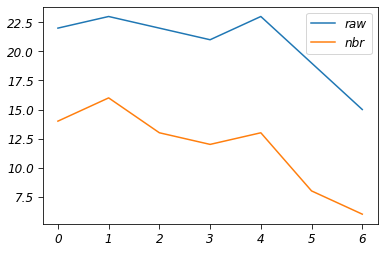

In [2084]:
# which SFs were most likely to show suppression?
plt.plot(np.sum(meet_thresh_sf, axis=0), label='raw')
plt.plot(np.sum(meet_thresh_sf_nb, axis=0), label='nbr')
plt.legend();

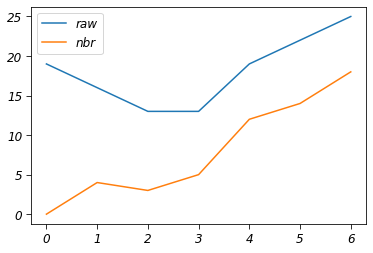

In [2085]:
# which cons were most likely to show suppression?
plt.plot(np.sum(meet_thresh_con, axis=0), label='raw');
plt.plot(np.sum(meet_thresh_con_nb, axis=0), label='nbr');
plt.legend();

Summary of statistics between cells that showed suppression after neighbor criterion and those whose classification as suppressed was removed:

*In short, the eliminated cells had far fewer conditions with measurable suppression, and had weaker and more variable base responses.*

In [2086]:
print('Prorties of cells that failed the neighbor inclusion criterion (True) vs. those that passed (False):')
print('-------------\n***Medians:***')
print(df_subset.groupby('suppr_elim_w_nb')[['nSuppr_noNb', 'meanSuppr_noNb', 'baseResp_mean','baseVarEst',
                                      'baseAsMaxFrac', 'meanResp', 'sfVarExpl_hiCon']].median())

print('-------------\n***Means:***')
print(df_subset.groupby('suppr_elim_w_nb')[['nSuppr_noNb', 'meanSuppr_noNb', 'baseResp_mean','baseVarEst',
                                      'baseAsMaxFrac', 'meanResp', 'sfVarExpl_hiCon']].mean())

Prorties of cells that failed the neighbor inclusion criterion (True) vs. those that passed (False):
-------------
***Medians:***
                 nSuppr_noNb  meanSuppr_noNb  baseResp_mean  baseVarEst  \
suppr_elim_w_nb                                                           
False                  8.000          -0.855         15.258       0.754   
True                   3.000          -0.623          4.539       0.974   

                 baseAsMaxFrac  meanResp  sfVarExpl_hiCon  
suppr_elim_w_nb                                            
False                    0.213    17.916           96.346  
True                     0.133    10.745           90.901  
-------------
***Means:***
                 nSuppr_noNb  meanSuppr_noNb  baseResp_mean  baseVarEst  \
suppr_elim_w_nb                                                           
False                  9.810          -1.015         27.931       3.780   
True                   2.737          -0.642          9.987       4.043   

 

### How many cells show suppression?
Any difference between simple & complex?

In [2087]:
ok_overall = np.array([np.any(x) for x in meet_thresh_neighbor])
print('%d out of %d show suppression' % (np.sum(ok_overall), nCells))

21 out of 47 show suppression


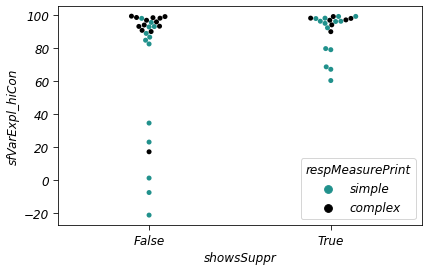

In [2088]:
# specs
halfsz = False;
scale = 0.5 if halfsz else 1

saveName = '02_00_varExpl_bySuppr%s.pdf' % ('_halfSz' if halfsz else '')

f = plt.figure(figsize=hf.set_size(scale*tex_width))

sns.swarmplot(data=df_subset, x='showsSuppr', y='sfVarExpl_hiCon', hue='respMeasurePrint', palette=area_colors[1])#.set_xticklabels(['No suppression', 'Suppression']);
vexp_thresh = 50;
df_subset_lowVEcut = df_subset[df_subset['sfVarExpl_hiCon']>vexp_thresh]

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

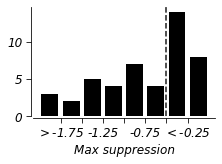

In [2089]:
onlyHiCon = True
halfsz = True;
scale = 0.5 if halfsz else 1

spec_str = '_onlyHiCon' if onlyHiCon else '';

saveName = '02_00_maxSuprDistr%s%s.pdf' % (spec_str, '_halfSz' if halfsz else '')

f = plt.figure(figsize=hf.set_size(scale*tex_width))

vls = df_subset['maxSuppr_all%s' % spec_str];

if suppr_ind==2:
    bins = np.linspace(-4,0,11); # suppr. rel to base stimulus response
else:
    bins = np.linspace(-2,0,9); # z-scored units
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;
width = 0.8*stepSize;

# vls = np.log2(hf.flatten_list(group[kywrd].values));
clipped = np.clip(vls, clipLow, clipHigh);
vals, _ = np.histogram(clipped, bins=bins)
    
plt.bar(binPlotLocs, vals, width=width, align='center', color=clr,
                 label='%s' % (name,));

tickStrs = ['%.2f' % x for x in tickVals];
tickStrs[0] = '$>$%s' % tickStrs[0];
tickStrs[-1] = '$<$%s' % tickStrs[-1];
if halfsz:
    tickStrs = [str_val if np.mod(str_i,2)==0 else '' for str_i,str_val in enumerate(tickStrs)]
plt.xticks(ticks=tickVals, labels=tickStrs);

# sns.histplot(data=df_subset, x='maxSuppr_all%s' % spec_str, color='k', 
#              fill=False, bins=np.linspace(-2, 0, 9))

plt.axvline(thresh_val, color='k', linestyle='--');
plt.xlabel('Max suppression')
sns.despine(offset=sns_offset)

for jj, axis in enumerate([plt.gca().xaxis, plt.gca().yaxis]):
    if jj==1: # i.e. y axis, make sure we have tick labels, here, too
        from matplotlib.ticker import MaxNLocator
        axis.set_major_locator(MaxNLocator(3, integer=True))

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

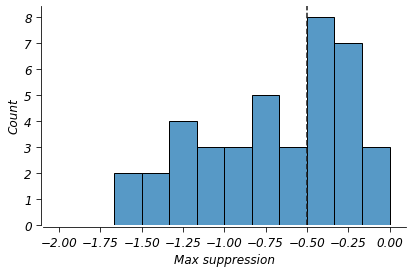

In [2090]:
onlyHiCon = True
spec_str = '_onlyHiCon' if onlyHiCon else '';

saveName = '02_00_maxSuprDistr%s.pdf' % spec_str

f = plt.figure(figsize=hf.set_size(tex_width))

sns.histplot(data=df_subset, x='maxSuppr_all%s' % spec_str, bins=np.linspace(-2, 0, 13))
plt.axvline(thresh_val, color='k', linestyle='--');
plt.xlabel('Max suppression')
sns.despine(offset=sns_offset)

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

In [2091]:
df_subset.groupby('respMeasurePrint')['showsSuppr'].value_counts()

respMeasurePrint  showsSuppr
complex           False         13
                  True           7
simple            True          14
                  False         13
Name: showsSuppr, dtype: int64

In [2092]:
print(df_subset.groupby('respMeasurePrint')['showsSuppr'].mean())
print('\n...and if we cut the lowVE ones:\n')
print(df_subset_lowVEcut.groupby('respMeasurePrint')['showsSuppr'].mean())

respMeasurePrint
complex   0.350
simple    0.519
Name: showsSuppr, dtype: float64

...and if we cut the lowVE ones:

respMeasurePrint
complex   0.368
simple    0.636
Name: showsSuppr, dtype: float64


In [2093]:
ovr_supr = df_subset['showsSuppr'].mean()
print('%d%% of cells overall show suppression' % (100*ovr_supr))
ovr_supr_cut = df_subset_lowVEcut['showsSuppr'].mean()
print('...%d%% if we cut the noisy ones' % (100*ovr_supr_cut))

44% of cells overall show suppression
...51% if we cut the noisy ones


##### And what about targeted vs. non-targeted?

In [2094]:
df_subset.groupby('wasTarget')['showsSuppr'].value_counts()

wasTarget  showsSuppr
False      False          8
           True           5
True       False         18
           True          16
Name: showsSuppr, dtype: int64

In [2096]:
df_subset.groupby('wasTarget')['baseAsMaxFrac'].agg(['mean', 'median'])

,mean,median
wasTarget,,
False,0.124,0.097
True,0.231,0.193


So, by this measure, a slightly greater fraction of simple cells shows suppression. This is likely due, in part, due to the greater difficulty in measuring suppression for DC responses! This discrepancy becomes larger if we filter out the very noisy cells (*e.g. sfVarExpl<80%*)

### What are the mask SFs relative to the cell's preference?

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='baseCon', ylabel='Density'>

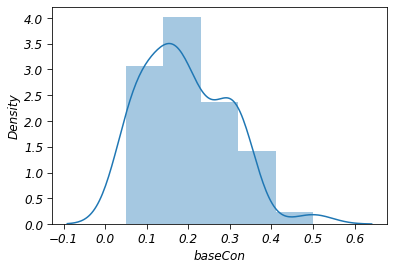

In [2097]:
sns.distplot(df_subset['baseCon'])

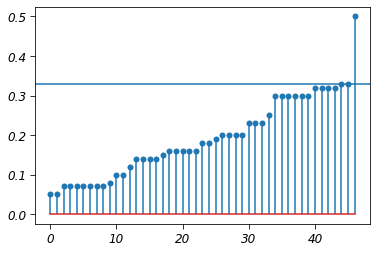

In [2098]:
plt.stem(sorted(df_subset['baseCon']))
plt.axhline(.33)

*Note that only one cell (V1_BB/6) had a base contrast higher than 0.32; accordingly, that cell had a reduced range of mask contrasts to ensure that the summed contrast never exceeded 1; this cell had very low firing rates and was excluded from the primary analyses, anyway, due to a lack of measurable suppression.*

In [2102]:
get_rats = lambda x: np.log2(np.unique(np.round(x[1:]/x[0:-1], 3)))
df_subset['maskSf'].apply(get_rats)

cellNum
1     [0.7501777055930572]
2     [0.7501777055930572]
3     [0.7501777055930572]
4     [0.7501777055930572]
5     [0.7501777055930572]
6     [0.7501777055930572]
7     [0.7501777055930572]
8     [0.7501777055930572]
9     [0.7501777055930572]
10    [0.7501777055930572]
11    [0.7501777055930572]
12    [0.7501777055930572]
13    [0.7501777055930572]
14    [0.7501777055930572]
15    [0.7501777055930572]
16    [0.7501777055930572]
17    [0.7501777055930572]
18    [0.7501777055930572]
19    [0.7501777055930572]
20    [0.7501777055930572]
21    [0.7501777055930572]
22    [0.7501777055930572]
23    [0.7501777055930572]
24    [0.7501777055930572]
25    [0.7501777055930572]
26    [0.7501777055930572]
27    [0.7501777055930572]
28    [0.7501777055930572]
29    [0.7501777055930572]
30    [0.7501777055930572]
31    [0.7501777055930572]
32    [0.7501777055930572]
33    [0.7501777055930572]
34    [0.7501777055930572]
35    [0.7501777055930572]
36    [0.7501777055930572]
37    [0.75017770559

The above tells us that the typical step between successive mask SFs was 0.75 octaves

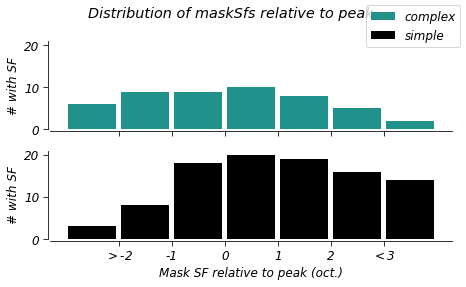

In [2104]:
saveName = '02_01_maskSfs_relPeak.pdf'

# first, how common are mask Sfs based on relation to the peak
bins = np.linspace(-3,4,8); # in octaves
# bins = np.linspace(-4,4,9); # in octaves
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;
width = hist_width*stepSize;

kywrd = 'maskSf_relPref';

f, ax = plt.subplots(2,1, figsize=hf.set_size(tex_width), sharex=True, sharey=True)
use_norm = False;
to_div = [];

for (plt_i, (name,group)), clr in zip(enumerate(only_suppr.groupby('respMeasurePrint')), colors):
    vls = np.log2(hf.flatten_list(group[kywrd].values));
    clipped = np.clip(vls, clipLow, clipHigh);
    vals, _ = np.histogram(clipped, bins=bins)
    vals_norm = vals/np.sum(vals)
    
    to_use = vals_norm if use_norm else vals;
    
    ax[plt_i].bar(binPlotLocs, to_use, width=width, align='center', color=clr,
                 label='%s' % (name,));
    
    to_div.append(to_use)
    
    tickStrs = ['%d' % x for x in tickVals];
    tickStrs[0] = '$>$%s' % tickStrs[0];
    tickStrs[-1] = '$<$%s' % tickStrs[-1];
    ax[plt_i].set_xticks(tickVals);
    ax[plt_i].set_xticklabels(tickStrs);
#     ax[plt_i].plot(np.nanmedian(vls), 1.2*np.nanmax(to_use), 'v', color=clr)
    if plt_i==1:
        ax[plt_i].set_xlabel('Mask SF relative to peak (oct.)')
    ax[plt_i].set_ylabel('# with SF')
    
f.suptitle('Distribution of maskSfs relative to peak')
f.legend()
f.tight_layout()
sns.despine(offset=sns_offset)

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

#### And, how common is suppression at a given SF?

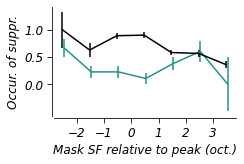

In [2105]:
halfsz = True;
incl_legend = False;
scale = 0.5 if halfsz else 1
incl_sem = True;

saveName = '02_02_suprOccurBySf%s%s.pdf' % ('_halfSz' if halfsz else '', '_noLgnd' if not incl_legend else '')

f = plt.figure(figsize=hf.set_size(scale*tex_width))

for (plt_i, (name,group)), divs, clr in zip(enumerate(only_suppr.groupby('respMeasurePrint')), to_div, colors):

    relPref, threshSf = np.vstack(group['maskSf_relPref']), np.vstack(group['thresh_sf'])
    meetsThresh = relPref[threshSf]
    vls = np.log2(meetsThresh);
    clipped = np.clip(vls, clipLow, clipHigh);
    vals, _ = np.histogram(clipped, bins=bins)
    vals_normed = vals/divs
    if incl_sem:
        plt.errorbar(binPlotLocs-((2*plt_i-1)*0.03), vals_normed, yerr=1/divs, label='%s [n=%d]' % (name, relPref.shape[0]), color=clr)
    else:
        plt.plot(binPlotLocs-((2*plt_i-1)*0.03), vals_normed, '-o', label='%s [n=%d]' % (name, relPref.shape[0]), color=clr)
    # slight offset to avoid overlapping...
    plt.xlabel('Mask SF relative to peak (oct.)')
    plt.ylabel('Occur. of suppr.')

# plt.title('Occurance of suppression by spatial frequency');
sns.despine(offset=sns_offset)
if incl_legend:
    plt.legend();

# adjust as needed for any specific plot
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=7))
plt.gca().yaxis.set_major_locator(mpl.ticker.FixedLocator([0,0.5,1]))
    
# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

In [2106]:
maskCons_overall = np.unique(np.round(hf.flatten_list(only_suppr['maskCon']), 2))# round to the nearest hundredth
if len(maskCons_overall)>8: # oy...
    print('needed to manually set mask contrasts --> did you somehow include a lot of cells?')
    maskCons_overall = np.geomspace(0.01, 0.64, 7)

### What is the tuning of the suppression?

In [2107]:
### plot for simple and complex

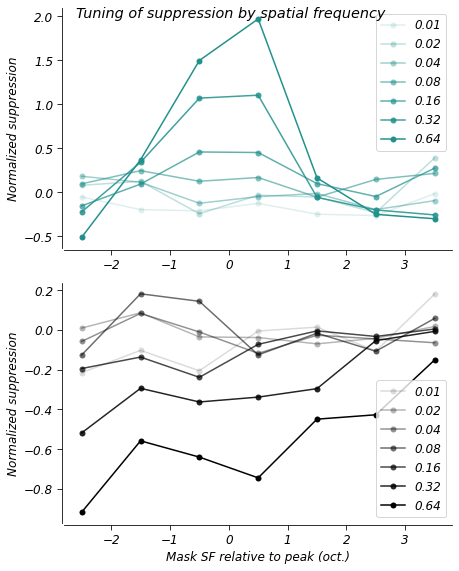

In [2108]:
cmplxOnlySuppr = False;

saveName = '02_03_avgSuprTuning%s.pdf' % ('_allComplexConds' if not cmplxOnlySuppr else '')

f, ax = plt.subplots(2,1, figsize=hf.set_size(tex_width, extra_height=2));

for (plt_i, (name,group)), divs, clr in zip(enumerate(only_suppr.groupby('respMeasurePrint')), to_div, colors):

    allThreshBin, allThreshVals, relPref = np.stack(group['thresh']), np.stack(group['baseDiffs']), np.vstack(group['maskSf_relPref'])
    # annoying transposes to get things working...
    allThreshVals_norm = np.divide(-allThreshVals[..., -1].T, np.nanmin(allThreshVals[...,-1], axis=(1, 2))).T

    for con_i in range(allThreshBin.shape[1]): # nCons
        curr_vals = allThreshVals_norm[:,con_i,:];
        
        curr_avg_supr = np.zeros((len(bins)-1, ));

        relPref, thresh = np.vstack(group['maskSf_relPref']), np.vstack(allThreshBin[:,con_i,:])
        # if DC (i.e. name=='complex'), then we should only average where suppression is present
        # --- otherwise, we can just sum up?
        if name=='complex' and cmplxOnlySuppr: # then we should subset only those that show suppr.
            curr_sfs = np.log2(relPref[thresh])
            curr_vals_pass = curr_vals[thresh]
            if curr_sfs.size==0: # nothing to plot
                continue;
        else: # we can add everything...
            curr_sfs = np.log2(relPref)
            curr_vals_pass = curr_vals
        # otherwise, let's count up how many times each binned (rel. SF) shows up, and average the tot. suppr
        curr_counts = np.histogram(np.clip(curr_sfs, clipLow,clipHigh), bins=bins)[0];
        curr_inds = np.digitize(np.clip(curr_sfs, clipLow,clipHigh), bins=bins)
        # in place op
        np.add.at(curr_avg_supr, curr_inds-1, curr_vals_pass)
        curr_avg_supr /= curr_counts
        nonan = ~np.isnan(curr_avg_supr);

        ax[plt_i].plot(binPlotLocs, curr_avg_supr, '-o', color=clr, 
                       alpha=(1+con_i)/allThreshBin.shape[1], label='%.2f' % (maskCons_overall[con_i]))
#         ax[plt_i].plot(binPlotLocs[nonan], curr_avg_supr[nonan], '-o', color='k', 
#                        alpha=(1+con_i)/allThreshBin.shape[1], label='%d%%' % (100*maskCons_overall[con_i]))
        
        if plt_i==1:
            ax[plt_i].set_xlabel('Mask SF relative to peak (oct.)')
        ax[plt_i].set_ylabel('Normalized suppression')
        ax[plt_i].legend();
f.tight_layout();
f.suptitle('Tuning of suppression by spatial frequency');
sns.despine(offset=sns_offset)

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

#### Including just for simple cells (or just complex)

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide


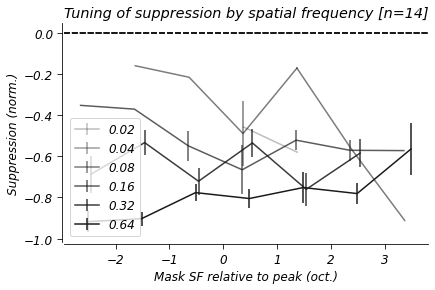

In [1309]:
onlySuprCells = True
onlySuprConds = True
incl_sem = True;

halfsz = False;
scale = 0.5 if halfsz else 1

useSimple = 1;

saveName = '02_03a_avgSuprTuning_only%s_%s_%s%s%s.pdf' % ('Simple' if useSimple else 'Complex', 'onlySuprCells' if onlySuprCells else 'allCells',
                                                         'onlySuprConds' if onlySuprConds else 'allConds',
                                                           '_noSEM' if not incl_sem else '',
                                                           '_halfSz' if halfsz else '')
# all cells
if onlySuprCells:
    to_use = only_suppr[only_suppr['respMeasure']==useSimple];
else:
    to_use = df_subset[df_subset['respMeasure']==useSimple];


allThreshBin, allThreshVals, relPref = np.stack(to_use['thresh']), np.stack(to_use['baseDiffs']), np.vstack(to_use['maskSf_relPref'])
# annoying transposes to get things working...
allThreshVals_norm = np.divide(-allThreshVals[..., -1].T, np.nanmin(allThreshVals[...,-1], axis=(1, 2))).T
# not norm by per-cell max
# allThreshVals_norm = allThreshVals[..., -1]

plt.figure(figsize=hf.set_size(scale*tex_width))

for con_i in range(allThreshBin.shape[1]): # nCons
    curr_vals = allThreshVals_norm[:,con_i,:];

    curr_avg_supr = np.zeros((len(bins)-1, ));

    relPref, thresh = np.vstack(to_use['maskSf_relPref']), np.vstack(allThreshBin[:,con_i,:])
    
    if onlySuprConds: # consider only conditions that meet suppression threshold
        curr_sfs = np.log2(relPref[thresh])
        curr_vals_pass = curr_vals[thresh]
        if curr_sfs.size==0: # nothing to plot
            continue;
    else: # consider all conditions
        curr_sfs = np.log2(relPref)
        curr_vals_pass = curr_vals
    
    curr_counts = np.histogram(np.clip(curr_sfs, clipLow,clipHigh), bins=bins)[0];
    curr_inds = np.digitize(np.clip(curr_sfs, clipLow,clipHigh), bins=bins)
    # in place op
    np.add.at(curr_avg_supr, curr_inds-1, curr_vals_pass)
    curr_avg_supr /= curr_counts
    # and some variance metric?
    stdz = np.zeros((len(bins)-1, ));
    stdz[np.unique(curr_inds)-1] = [np.nanstd(curr_vals_pass[curr_inds==x]) for x in np.unique(curr_inds)]
    varz = np.zeros((len(bins)-1, ));
    varz[np.unique(curr_inds)-1] = [np.nanvar(curr_vals_pass[curr_inds==x]) for x in np.unique(curr_inds)]

    sem_est = stdz/np.sqrt(curr_counts) # s.e.m.?

    if incl_sem:
        curr_jitter = hf.random_in_range([-0.15,0.15])[0];
        plt.errorbar(binPlotLocs+curr_jitter, curr_avg_supr, yerr=sem_est, color='k', 
                   alpha=(1+con_i)/allThreshBin.shape[1], label='%.2f' % (maskCons_overall[con_i]))
    else:
        plt.plot(binPlotLocs, curr_avg_supr, '-o', color='k', 
                   alpha=(1+con_i)/allThreshBin.shape[1], label='%.2f' % (maskCons_overall[con_i]))


    if plt_i==1:
        plt.xlabel('Mask SF relative to peak (oct.)')
    plt.ylabel('Suppression (norm.)')
    plt.legend();
    plt.axhline(0, color='k', linestyle='--')
    
f.tight_layout();
plt.title('Tuning of suppression by spatial frequency [n=%d]' % to_use.shape[0]);
sns.despine(offset=sns_offset)

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

### *Quick* look at relationship between suppression and other characteristics?

First, not split by DC/F1, then split by DC/F1:

In [2119]:
# curr_subset = df_subset
curr_subset = df_subset[df_subset['wasTarget']]

In [2121]:
to_test = ['f1f0_ratio', 'meanResp', 'maxResp', 'baseResp_mean', 'baseVarEst', 'baseAsMaxFrac',
           'dog_mod_slope', 'dog_bwHalf_hiCon', 'dog_bw34_hiCon', 'charFreq', 'sfPref', 'sfVarExpl_hiCon',
           'rfsize.gsf_model', 'rfsize.surrDiam_model', 'rfsize.suprInd_model', 
             'ori.bw', 'tf.tfBW_oct', 'tf.tfPref']

for fld in to_test:
    valz = (*curr_subset.groupby('showsSuppr')[fld].apply(np.array), )
    ncells = [len(hf.nan_rm(x)) for x in valz]
    tst_t = ss.ttest_ind(*valz, nan_policy='omit')
    tst_k = ss.ks_2samp(*valz, )

    print('%s %.2f[%d] vs %.2f[%d]: \n\tp=%.2e [t]\n\tp=%.2e [ks]' % (fld, np.nanmean(valz[0]), ncells[0], 
                                                  np.nanmean(valz[1]), ncells[1], tst_t.pvalue, tst_k.pvalue))

f1f0_ratio 0.84[17] vs 1.27[16]: 
	p=1.47e-01 [t]
	p=3.72e-01 [ks]
meanResp 14.08[18] vs 24.63[16]: 
	p=2.74e-02 [t]
	p=6.70e-02 [ks]
maxResp 76.80[18] vs 119.03[16]: 
	p=1.87e-02 [t]
	p=5.97e-02 [ks]
baseResp_mean 11.83[18] vs 42.19[16]: 
	p=7.32e-04 [t]
	p=4.25e-03 [ks]
baseVarEst 4.83[18] vs 4.08[16]: 
	p=6.34e-01 [t]
	p=4.88e-03 [ks]
baseAsMaxFrac 0.14[18] vs 0.33[16]: 
	p=7.91e-04 [t]
	p=3.06e-02 [ks]
dog_mod_slope -0.12[18] vs -0.08[16]: 
	p=5.75e-01 [t]
	p=5.49e-01 [ks]
dog_bwHalf_hiCon 2.51[14] vs 1.80[7]: 
	p=3.20e-02 [t]
	p=2.11e-01 [ks]
dog_bw34_hiCon 1.75[16] vs 1.50[12]: 
	p=3.39e-01 [t]
	p=9.01e-01 [ks]
charFreq 663.87[18] vs 2.07[16]: 
	p=3.53e-01 [t]
	p=1.02e-01 [ks]
sfPref 1.25[18] vs 1.02[16]: 
	p=4.02e-01 [t]
	p=2.61e-01 [ks]
sfVarExpl_hiCon 66.63[18] vs 93.92[16]: 
	p=2.12e-02 [t]
	p=1.53e-01 [ks]
rfsize.gsf_model 2.18[18] vs 1.45[16]: 
	p=2.27e-01 [t]
	p=3.14e-01 [ks]
rfsize.surrDiam_model 5.27[18] vs 5.06[16]: 
	p=7.54e-01 [t]
	p=3.14e-01 [ks]
rfsize.suprInd_model

In [2109]:
to_test = ['f1f0_ratio', 'meanResp', 'maxResp', 'baseResp_mean', 'baseVarEst', 'baseAsMaxFrac',
           'dog_mod_slope', 'dog_bwHalf_hiCon', 'dog_bw34_hiCon', 'charFreq', 'sfPref', 'sfVarExpl_hiCon',
           'rfsize.gsf_model', 'rfsize.surrDiam_model', 'rfsize.suprInd_model', 
             'ori.bw', 'tf.tfBW_oct', 'tf.tfPref']

for (name,df_subset_) in df_subset.groupby('respMeasurePrint'):
    print('\n*****\nAnalysis for %s cells:\n****\n' % name);
    for fld in to_test:
        valz = (*df_subset_.groupby('showsSuppr')[fld].apply(np.array), )
        ncells = [len(hf.nan_rm(x)) for x in valz]
        tst_t = ss.ttest_ind(*valz, nan_policy='omit')
        tst_k = ss.ks_2samp(*valz, )

        print('%s %.2f[%d] vs %.2f[%d]: \n\tp=%.2e [t]\n\tp=%.2e [ks]' % (fld, np.nanmean(valz[0]), ncells[0], 
                                                      np.nanmean(valz[1]), ncells[1], tst_t.pvalue, tst_k.pvalue))


*****
Analysis for complex cells:
****

f1f0_ratio 0.47[13] vs 0.41[7]: 
	p=5.14e-01 [t]
	p=5.35e-01 [ks]
meanResp 16.76[13] vs 29.07[7]: 
	p=9.04e-02 [t]
	p=2.99e-01 [ks]
maxResp 86.31[13] vs 152.57[7]: 
	p=1.11e-02 [t]
	p=1.69e-01 [ks]
baseResp_mean 17.70[13] vs 60.11[7]: 
	p=1.01e-03 [t]
	p=1.20e-02 [ks]
baseVarEst 8.09[13] vs 9.04[7]: 
	p=7.00e-01 [t]
	p=1.11e-01 [ks]
baseAsMaxFrac 0.20[13] vs 0.38[7]: 
	p=6.95e-03 [t]
	p=3.64e-02 [ks]
dog_mod_slope -0.14[13] vs -0.20[7]: 
	p=5.82e-01 [t]
	p=6.41e-01 [ks]
dog_bwHalf_hiCon 2.54[10] vs 1.76[5]: 
	p=4.77e-02 [t]
	p=1.69e-01 [ks]
dog_bw34_hiCon 1.82[12] vs 1.37[7]: 
	p=2.20e-01 [t]
	p=5.88e-01 [ks]
charFreq 2.35[13] vs 2.30[7]: 
	p=9.07e-01 [t]
	p=4.83e-01 [ks]
sfPref 1.33[13] vs 1.49[7]: 
	p=6.49e-01 [t]
	p=4.83e-01 [ks]
sfVarExpl_hiCon 89.73[13] vs 96.34[7]: 
	p=4.46e-01 [t]
	p=5.88e-01 [ks]
rfsize.gsf_model 2.60[13] vs 1.84[7]: 
	p=4.61e-01 [t]
	p=3.44e-01 [ks]
rfsize.surrDiam_model 5.20[13] vs 5.24[7]: 
	p=9.60e-01 [t]
	p=5.35e-01

#### Some selected correlations?

nSuppr, meanSuppr, maxSuppr are three measures to consider!

In [2110]:
if log_y:
    orig_vals = which_data_curr[y];
    which_data_curr['%s_log' % y] = np.sign(orig_vals) * np.log(np.abs(orig_vals));

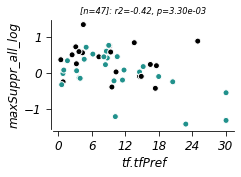

In [2115]:
halfsz = True;
scale = 0.5 if halfsz else 1

log_y = True
# log_y = False

only_f1 = False

# can be eval. for all
y = 'maxSuppr_all'
# only for suppr. cells
# y = 'meanSuppr'
# y = 'maxSuppr'
# y = 'nSuppr'

# x = 'baseResp_mean'
# x = 'baseAsMaxFrac'
# x = 'baseAsMeanFrac'
# x = 'dog_bwHalf_hiCon'
# x = 'dog_bw34_hiCon'
# x = 'sfVarExpl_hiCon'
# x = 'rfsize.suprInd_model'
# x= 'sfPref'
# x = 'tf.tfBW_oct'
x = 'tf.tfPref'
# x = 'rfsize.surrDiam_model'
# x = 'rfsize.gsf_model'
# x = 'dog_mod_slope'

which_data_curr = df_subset
if only_f1:
    which_data_curr = which_data_curr[which_data_curr['respMeasure']==1];

saveName = '02_04a_%s_%s%s%s%s.pdf' % (x,y, '_halfSz' if halfsz else '', '_lgY' if log_y else '', '_onlyF1')

f = plt.figure(figsize=hf.set_size(scale*tex_width))

if log_y:
    orig_vals = which_data_curr[y];
    y = '%s_log' % y; # rename y
    which_data_curr[y] = np.sign(orig_vals) * np.log(np.abs(orig_vals));

if only_f1:
    sns.scatterplot(data=which_data_curr, x=x, y=y, alpha=1, edgecolor='w', linewidth=1,legend=False, color='k');
else: # then we color/separate by F1
    sns.scatterplot(data=which_data_curr, x=x, y=y, alpha=1, edgecolor='w', linewidth=1, hue='respMeasurePrint', 
                palette=colors, legend=False, color='k');
r2, p, n = pearson_r_pandas(which_data_curr, x, y);
plt.xlabel(x);
plt.ylabel(y);
plt.title('[n=%d]: r2=%.2f, p=%.2e' % (n, r2, p), fontsize='x-small')

# adjust as needed for any specific plot
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=6))

sns.despine(offset=sns_offset)

# # now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()